# Multivariate fine-mapping with missing data examples

This notebook applies mvSuSiE on some GTEx genes using two approaches to handle missing data.

## Input

We focus on the 27 genes identified in MASH paper that seems to have different direction of effects in brain vs non-brain tissues. It is of interesting to look at these examples with multivariate fine-mapping.

## Analysis

### Compute prior

```
sos run analysis/gtex-v8/20200906_mvSuSiE_GTEx.ipynb factor_analysis
sos run analysis/gtex-v8/20200906_mvSuSiE_GTEx.ipynb mixture_model
```

### Analyze the data

```
sos dryrun analysis/gtex-v8/20200906_mvSuSiE_GTEx.ipynb submit \
    --wd  /project2/compbio/GTEx_eQTL/mvSuSiE_output/cis_results  \
    --name 20210409
```

## Results

### Mixture analysis results

> /project2/compbio/GTEx_eQTL/mvSuSiE_output/GTEx_V8_strong_z.ed.pdf (500.8 KiB):

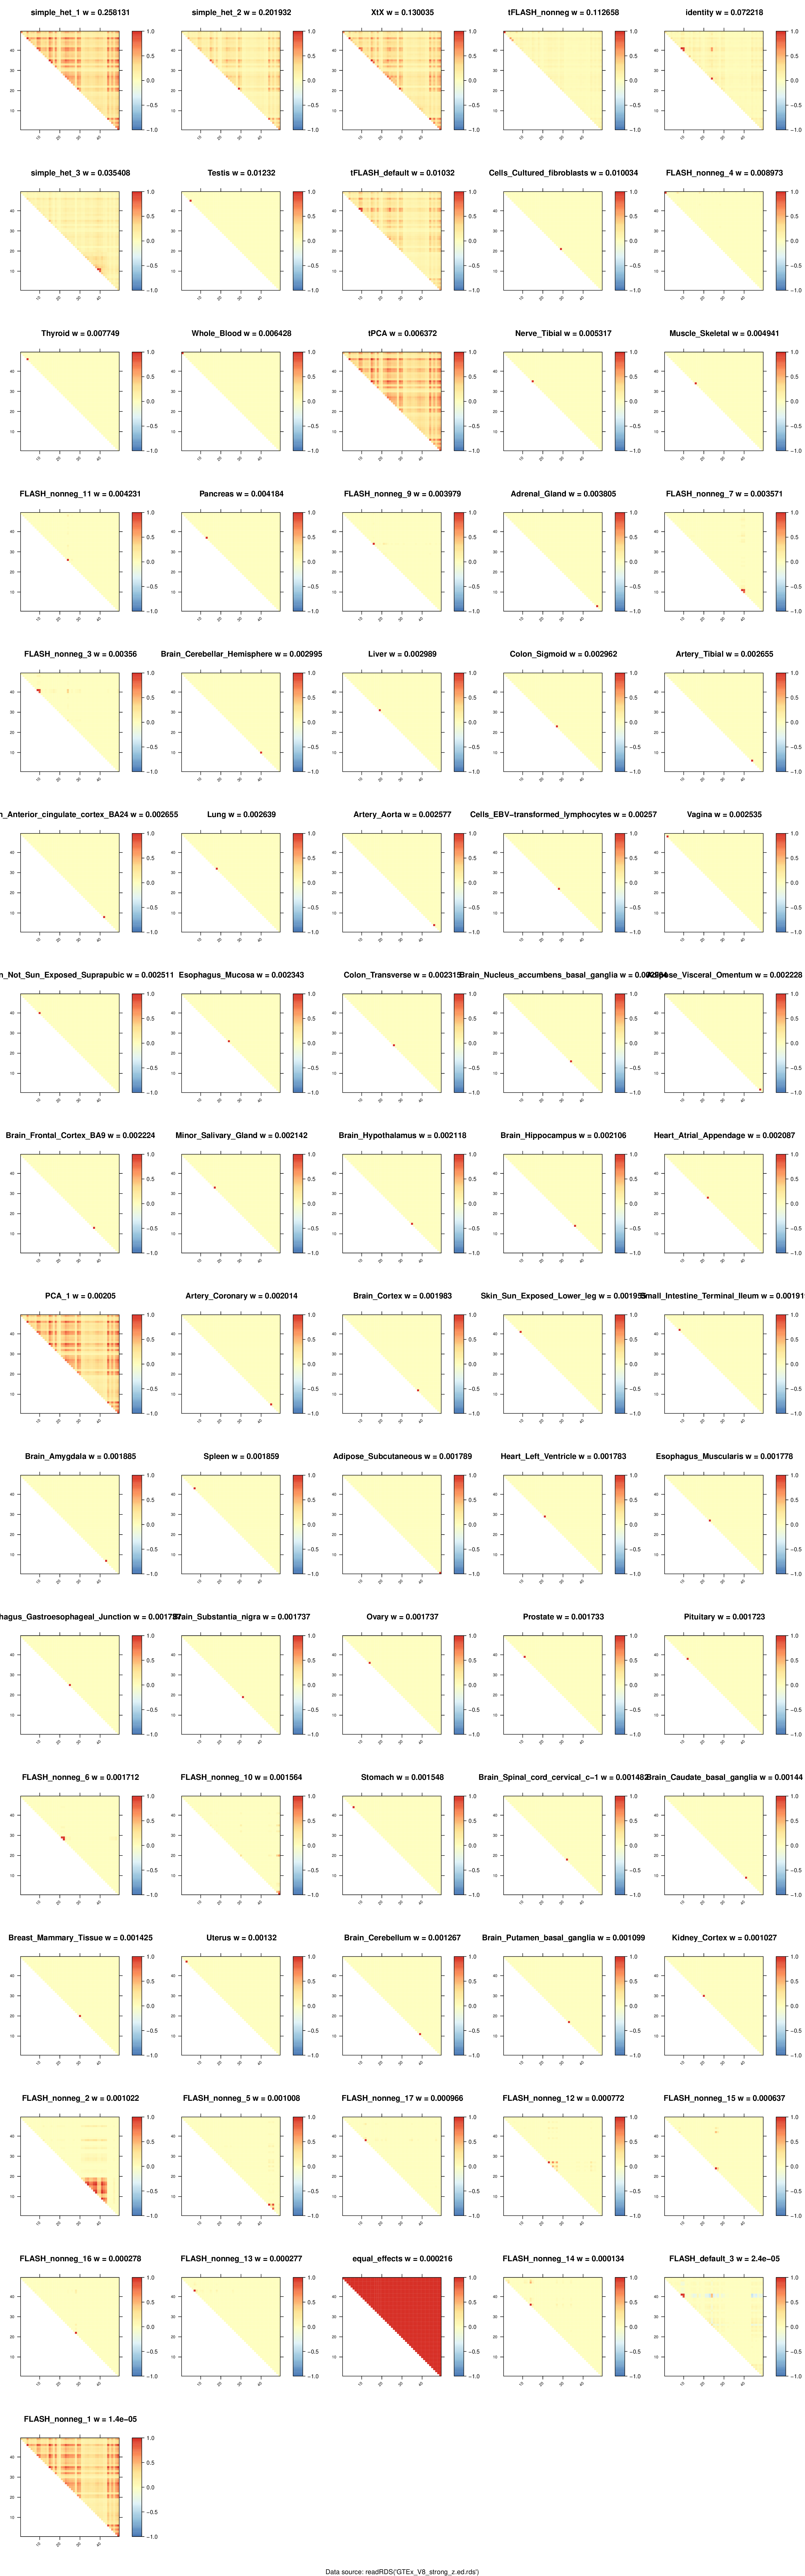

In [1]:
%preview -s png /project2/compbio/GTEx_eQTL/mvSuSiE_output/GTEx_V8_strong_z.ed.pdf -s png

> /project2/compbio/GTEx_eQTL/mvSuSiE_output/GTEx_V8_strong_z.teem.pdf (609.3 KiB):

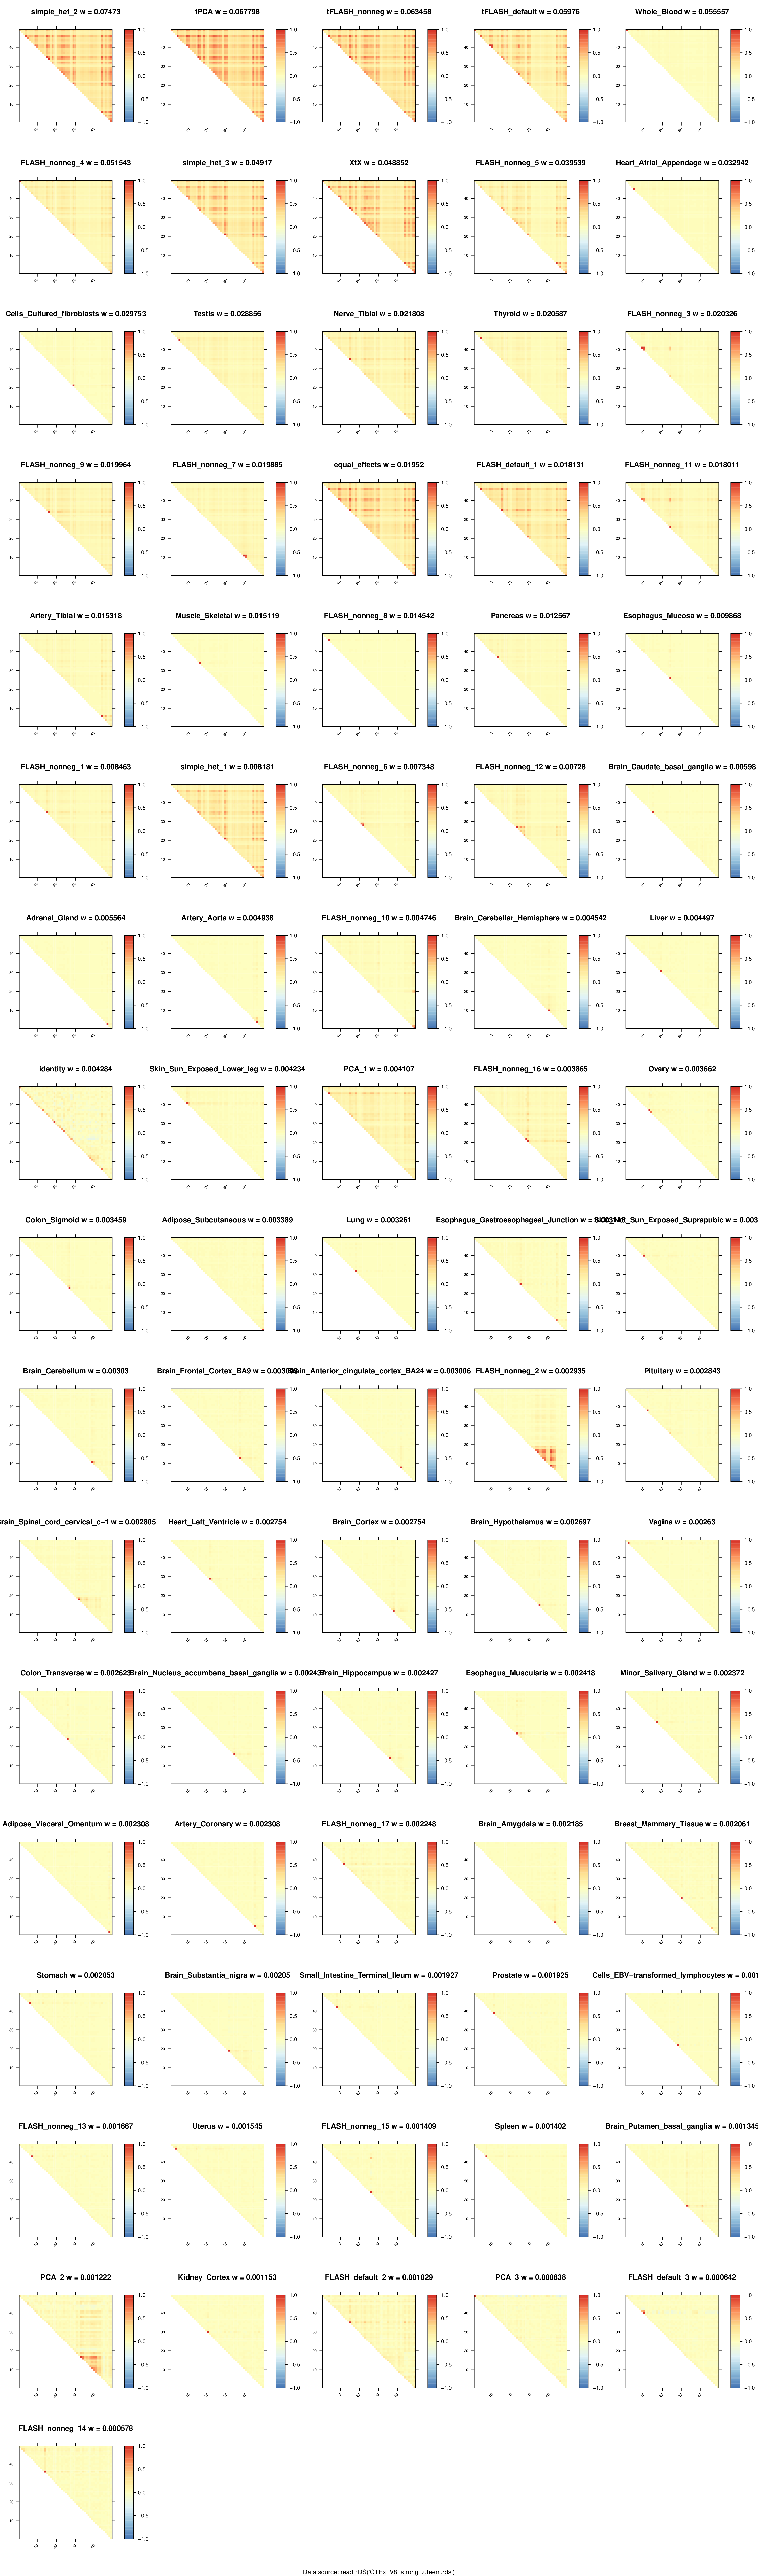

In [2]:
%preview -s png /project2/compbio/GTEx_eQTL/mvSuSiE_output/GTEx_V8_strong_z.teem.pdf -s png

In [ ]:
[global]
parameter: wd = path('/project2/compbio/GTEx_eQTL/mvSuSiE_output')
parameter: name = "GTEx_V8_strong_z"

In [ ]:
[factor_analysis_1]
parameter: sumstat = path("/project2/compbio/GTEx_eQTL/mashr_flashr_workflow_output/FastQTLSumStats.mash.rds")
input: sumstat
output: f"{wd:a}/{name}.rds"
R: expand = True
    dat = readRDS({_input:r})
    attach(dat)
    random.tmp = rbind(random.b/random.s, random.test.b/random.test.s)
    null.id =  which(apply(abs(random.tmp), 1, max) < 2)
    null.z = random.tmp[null.id,,drop=F]
    null.cor = cor(null.z)
    z = strong.b/strong.s
    XtX = t(as.matrix(z)) %*% as.matrix(z) / nrow(z)
    res = list(null.cor = null.cor, strong.z = z, XtX = XtX)
    saveRDS(res, {_output:r})

In [ ]:
[factor_analysis_2]
script: interpreter= 'qsub', expand = True
    #!/bin/bash

    #SBATCH --time=36:00:00
    #SBATCH --partition=broadwl
    #SBATCH --nodes=1
    #SBATCH --ntasks-per-node=1
    #SBATCH --cpus-per-task=1
    #SBATCH --mem-per-cpu=2000
    #SBATCH --job-name={step_name}
    #SBATCH --mail-type=BEGIN,END,FAIL

    module load R
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb flash --name {name} --cwd {wd} -s build &> {wd}/{name}_factor_analysis.log
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb flash_nonneg --name {name} --cwd {wd} -s build &>> {wd}/{name}_factor_analysis.log
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb pca --name {name} --cwd {wd} -s build &>> {wd}/{name}_factor_analysis.log
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb canonical --name {name} --cwd {wd} -s build &>> {wd}/{name}_factor_analysis.log

In [ ]:
[mixture_model]
def get_cmd(m):
    c1 = f'''
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb ud --name {m} --cwd {wd} \
        -c ~/GIT/mvarbvs/midway2.yml -q midway2 -s build &> {wd}/ed_{m}.log
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb plot_U --name "" --cwd {wd} --model-data {wd}/{m}.ed.rds --remove-label \
        -c ~/GIT/mvarbvs/midway2.yml -q midway2 -s build
    '''
    c2 = f'''
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb ud --ud-method teem --name {m} --cwd {wd} \
        -c ~/GIT/mvarbvs/midway2.yml -q midway2 -s build &> {wd}/teem_{m}.log
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb plot_U --name "" --cwd {wd} --model-data {wd}/{m}.teem.rds --remove-label \
        -c ~/GIT/mvarbvs/midway2.yml -q midway2 -s build
    '''
    c3 = f'''
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb ed --name {m} --cwd {wd} \
        -c ~/GIT/mvarbvs/midway2.yml -q midway2 -s build &> {wd}/bovy_{m}.log
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mixture_prior.ipynb plot_U --name "" --cwd {wd} --model-data {wd}/{m}.ed_bovy.rds --remove-label \
        -c ~/GIT/mvarbvs/midway2.yml -q midway2 -s build
    '''
    return [c1,c2,c3]
cmds = get_cmd(name)
input: for_each = 'cmds'
script: interpreter= 'qsub', expand = True
    #!/bin/bash

    #SBATCH --time=36:00:00
    #SBATCH --partition=broadwl
    #SBATCH --nodes=1
    #SBATCH --ntasks-per-node=1
    #SBATCH --cpus-per-task=1
    #SBATCH --mem-per-cpu=2000
    #SBATCH --job-name={step_name}
    #SBATCH --mail-type=BEGIN,END,FAIL

    module load R
    {_cmds}

In [ ]:
[submit]
script: interpreter= 'qsub', expand = True
    #!/bin/bash

    #SBATCH --time=96:00:00
    #SBATCH --partition=mstephens
    #SBATCH --account=pi-mstephens
    #SBATCH --nodes=1
    #SBATCH --ntasks-per-node=1
    #SBATCH --cpus-per-task=8
    #SBATCH --mem-per-cpu=2000
    #SBATCH --job-name={step_name}
    #SBATCH --mail-type=BEGIN,END,FAIL

    module load R
    sos run ~/GIT/bioworkflows/multivariate-fine-mapping/mvSuSiE.ipynb \
        --analysis-units data/27_brain_non_brain_genes_v8.txt \
        --data-dir /project2/compbio/GTEx_eQTL/cis_eqtl_analysis_ready \
        --data-suffix GTEx_V8.rds \
        --name {name} \
        --wd {wd} \
        --prior /project2/compbio/GTEx_eQTL/mvSuSiE_output/GTEx_V8_strong_z.teem.rds \
        -c midway2.yml -q midway2 \
        -s build -e ignore &> gtex_v8.log